Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

--Assume already downloaded and processed data.

In [2]:
load = pickle.load(open("notMNIST.pickle", "rb"))

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print('Extracting data for %s. This may take a while. Please wait.' % root)
  sys.stdout.flush()
  tar.extractall()
  tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = ['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
test_folders = ['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print(folder)
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError("cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")
notMNIST_large/B
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'",), "- it's ok, skipping.")
notMNIST_large/C
notMNIST_large/D
('Could not read:', 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_larg

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

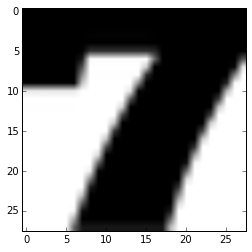

In [15]:
%matplotlib inline
plt.imshow(load["train_dataset"][5], cmap='binary')

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [6]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

In [ ]:
%matplotlib inline
plt.imshow(load["train_dataset"][5], cmap='binary')

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

1


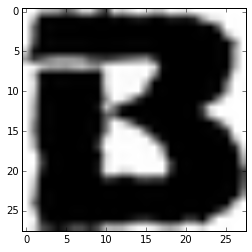

In [3]:
%matplotlib inline
index = np.random.randint(load["train_labels"].shape[0])
plt.imshow(load["train_dataset"][index], cmap="binary")
print load["train_labels"][index]

(array([ 20066.,  19720.,  20107.,  19904.,  20094.,  20044.,  20157.,
         20036.,  19910.,  19962.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

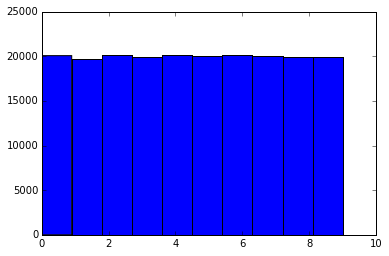

In [32]:
plt.hist(load["train_labels"])

Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [8]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)

('Training', (200000, 28, 28), (200000,))
('Validation', (10000, 28, 28), (10000,))


Finally, let's save the data for later reuse:

In [10]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 718193801)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [3]:
train_dataset = load["train_dataset"]
test_dataset = load["test_dataset"]
valid_dataset = load["valid_dataset"]

print 'Training data shape: ' + str(train_dataset.shape)
print 'Test data shape: ' + str(test_dataset.shape)
print 'Cross Validation data shape: ' + str(valid_dataset.shape)

train_dataset.flags.writeable = False
test_dataset.flags.writeable = False
valid_dataset.flags.writeable = False

dup_train_indices = []
dup_test_indices = []
dup_valid_indices = []

dup_table={}

dup_train = 0
dup_test = 0
dup_valid = 0

for idx,img in enumerate(train_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
       dup_train_indices.append(idx)
       
    dup_table[h] = idx

for idx,img in enumerate(test_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        dup_test_indices.append(idx)
        
for idx,img in enumerate(valid_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        dup_valid_indices.append(idx)

train_dataset.flags.writeable = True
test_dataset.flags.writeable = True
valid_dataset.flags.writeable = True

load["train_dataset"] = np.delete(train_dataset, dup_train_indices, 0)
load["train_labels"] = np.delete(load["train_labels"], dup_train_indices, 0)

load["test_dataset"] = np.delete(test_dataset, dup_test_indices, 0)
load["test_labels"] = np.delete(load["test_labels"], dup_test_indices, 0)

load["valid_dataset"] = np.delete(valid_dataset, dup_valid_indices, 0)
load["valid_labels"] = np.delete(["valid_labels"], dup_valid_indices, 0)
    
del train_dataset
del test_dataset
del valid_dataset

print 'I have removed: ' + str(len(dup_train_indices)) + ' images from the train data'
print 'I have removed: ' + str(len(dup_test_indices)) + ' images from the test data'
print 'I have removed: ' + str(len(dup_valid_indices)) + ' images from the cross validation data'


print 'Training data shape: ' + str(load["train_dataset"].shape)
print 'Test data shape: ' + str(load["test_dataset"].shape)
print 'Cross Validation data shape: ' + str(load["valid_dataset"].shape)

Training data shape: (200000, 28, 28)
Test data shape: (18724, 28, 28)
Cross Validation data shape: (10000, 28, 28)
I have removed: 12365 images from the train data
I have removed: 2428 images from the test data
I have removed: 1100 images from the cross validation data
Training data shape: (187635, 28, 28)
Test data shape: (16296, 28, 28)
Cross Validation data shape: (8900, 28, 28)


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [16]:
logistic_classifier = LogisticRegression(C=100.0, solver='lbfgs', max_iter=25)
logistic_classifier.fit(load["train_dataset"].reshape((load["train_dataset"].shape[0], 784)), load["train_labels"])

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=15, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

In [17]:
from sklearn import metrics
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        load["test_labels"],
        logistic_classifier.predict(load["test_dataset"].reshape((load["test_dataset"].shape[0], 784)))
        ))
      )

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.90      0.88      0.89      1648
          1       0.90      0.86      0.88      1658
          2       0.88      0.92      0.90      1642
          3       0.90      0.91      0.91      1647
          4       0.89      0.84      0.86      1673
          5       0.86      0.92      0.89      1664
          6       0.90      0.87      0.88      1681
          7       0.91      0.86      0.88      1629
          8       0.82      0.81      0.81      1385
          9       0.84      0.91      0.88      1669

avg / total       0.88      0.88      0.88     16296


